# Exercise 5 - Multicompartment Hodgkin & Huxley Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

from matplotlib import rcParams
% matplotlib inline

In [58]:
rcParams.update({'font.size': 21})

## Equations

### Constants

In [3]:
C_m = 1 #membrane capacitance, in uF/cm^2

g_Na = 120.0 #maximum conducances, in mS/cm^2
g_K  = 36.0
g_L  = 0.3

V_Na = 115 #Nernst reversal potentials, in mV
V_K  = -12
V_L  = 10.6
V_rest = 0
num_comp = 100

In [4]:
g_axon = 0.1 
r_axon = 2*10e-4
l_comp = 0.1 * 10e-3
Ra = g_axon * l_comp / (np.pi * r_axon**2)
Ra

7.9577471545947684

In [5]:
dt = 25*10e-3
t = np.arange(0,100,dt)
one_ms = int(1 / dt)

### Rate equations V in mV:
non-linear paramiters alfa and beta

In [6]:
def alpha_m(u): return (2.5 - 0.1 * u) / (np.exp(2.5 - 0.1 * u) - 1)
def alpha_n(u): return (0.1 - 0.01 * u) / (np.exp(1 - 0.1 * u ) - 1)
def alpha_h(u): return (0.07 * np.exp(-u / 20))

def beta_m(u):  return 4 * np.exp((-u) / 18)
def beta_n(u):  return 0.125 * np.exp((-u) / 80)
def beta_h(u):  return 1 / (np.exp(3 - 0.1 * u) + 1)

### Temperature correction

In [7]:
def temp_corr(T): return 3**(0.1*(T-6.3))  

### Time constants
τx(u)=[αx(u)+βx(u)] ^ −1

In [8]:
def tau_m(u): return (alpha_m(u) + beta_m(u))**(-1)
def tau_n(u): return (alpha_n(u) + beta_n(u))**(-1)
def tau_h(u): return (alpha_h(u) + beta_h(u))**(-1)

In [9]:
def m_ss(u): return alpha_m(u) / (alpha_m(u) + beta_m(u))
def n_ss(u): return alpha_n(u) / (alpha_n(u) + beta_n(u))
def h_ss(u): return alpha_h(u) / (alpha_h(u) + beta_h(u))

## Hodgkin & Huxley Neuro Model
implement a function that calculates the ionic current density i_ion, 
use the exponential-euler solver



In [10]:
def dm_du(m, u): return alpha_m(u) * (1 - m) - beta_m(u) * m
def dn_du(n, u): return alpha_n(u) * (1 - n) - beta_n(u) * n
def dh_du(h, u): return alpha_h(u) * (1 - h) - beta_h(u) * h

## Model

In [11]:
def hh_current(M, N, H, u):
    INa = g_Na * (M**3 * H) * (u - V_Na)  #sodium channel
    IK  = g_K  * (N**4    ) * (u - V_K)   #potas
    IL  = g_L               * (u - V_L)

    return INa + IK + IL

In [12]:
def hh_model_exp(temp, T, dt, I_stim):
    t = np.linspace(0, T, int(T/dt))
    M = np.zeros_like(t)
    N = np.zeros_like(t)
    H = np.zeros_like(t)
    U = np.zeros_like(t)
        
    M[0], N[0], H[0] = m_ss(0), n_ss(0), h_ss(0)
    k = temp_corr(temp)
    
    for n in range(0, len(I_stim)-1):
        u = U[n]
        A_m = -1 * k * (alpha_m(u) + beta_m(u))
        A_n = -1 * k * (alpha_n(u) + beta_n(u))
        A_h = -1 * k * (alpha_h(u) + beta_h(u))
        B_m = k * alpha_m(u)
        B_n = k * alpha_n(u)
        B_h = k * alpha_h(u)
      
        M[n+1] = M[n] * np.exp(A_m * dt) + B_m/A_m * (np.exp(A_m * dt)-1)
        N[n+1] = N[n] * np.exp(A_n * dt) + B_n/A_n * (np.exp(A_n * dt)-1)
        H[n+1] = H[n] * np.exp(A_h * dt) + B_h/A_h * (np.exp(A_h * dt)-1)
        
        I_ion = hh_current(M[n+1], N[n+1], H[n+1], u)
        U[n+1] = U[n] - 1/C_m * (I_ion - I_stim[n]) * dt
    return U, M, N, H

In [13]:
dt = 0.01
l = 100/dt
t = np.linspace(0, 100, int(l))
I1 = np.repeat(0, int(l))
hh_model_exp(6.3, 100, dt, I1)

(array([0.00000000e+00, 3.23709182e-06, 6.45278506e-06, ...,
        2.77566284e-04, 2.77566284e-04, 2.77566284e-04]),
 array([0.05293249, 0.05293249, 0.05293249, ..., 0.05293422, 0.05293422,
        0.05293422]),
 array([0.31767691, 0.31767691, 0.31767691, ..., 0.31768117, 0.31768117,
        0.31768117]),
 array([0.59612075, 0.59612075, 0.59612075, ..., 0.59611105, 0.59611105,
        0.59611105]))

## Multicompartment Model Adaptation 

### Connectivity Matrix

In [14]:
C = np.identity(100)
np.fill_diagonal(C, -2)
C[0][0] = -1
C[-1][-1] = -1

for i in range(0,100):
    for j in range(0,100):
        if i==j+1:
            C[i][j] = 1
        if i==j-1:
            C[i][j] = 1

C

array([[-1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1., -2.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1., -2., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -2.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1., -2.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1., -1.]])

In [17]:
def hh_model_exp_multi(num, temp, T, dt, I_stim):
    l = len(T)
    print(l)
    M = np.zeros((num,l))
    N = np.zeros((num,l))
    H = np.zeros((num,l))

    I = np.identity(num)
    U = np.zeros((num,l))

    M[:,0] = np.ones(num) * m_ss(0)
    N[:,0] = np.ones(num) * n_ss(0)
    H[:,0] = np.ones(num) * h_ss(0)
    k = temp_corr(temp)

    for t in np.arange(0, l - 1):
        
        u = U[:,t]
        I_ion = hh_current(M[:,t], N[:,t], H[:,t], u)
        b = U[:, t] + (dt/C_m) * (-I_ion + I_stim[:, t+1])
        A = (I - (dt/(C_m * Ra)) * C)
#         print('A', A) 
#         print('b',b)
        U[:, t+1] = np.linalg.solve(A,b)
    
        
        A_m = -1 * k * (alpha_m(u) + beta_m(u))
        A_n = -1 * k * (alpha_n(u) + beta_n(u))
        A_h = -1 * k * (alpha_h(u) + beta_h(u))
        B_m = k * alpha_m(u)
        B_n = k * alpha_n(u)
        B_h = k * alpha_h(u)

        M[:,t+1] = M[:,t] * np.exp(A_m * dt) + B_m/A_m * (np.exp(A_m * dt)-1)
        N[:,t+1] = N[:,t] * np.exp(A_n * dt) + B_n/A_n * (np.exp(A_n * dt)-1)
        H[:,t+1] = H[:,t] * np.exp(A_h * dt) + B_h/A_h * (np.exp(A_h * dt)-1)

    
    return U

In [31]:
# T = 100
# dt = 0.01
dt = 10e-4
num_comp = 100

T = np.arange(0,100,dt)
one_ms = int(1 / dt)
inp = np.zeros((num_comp,len(T)))
inp[0, 1:5*one_ms] = 10

V = hh_model_exp_multi(num_comp, 6.3, T, dt, inp)

100000


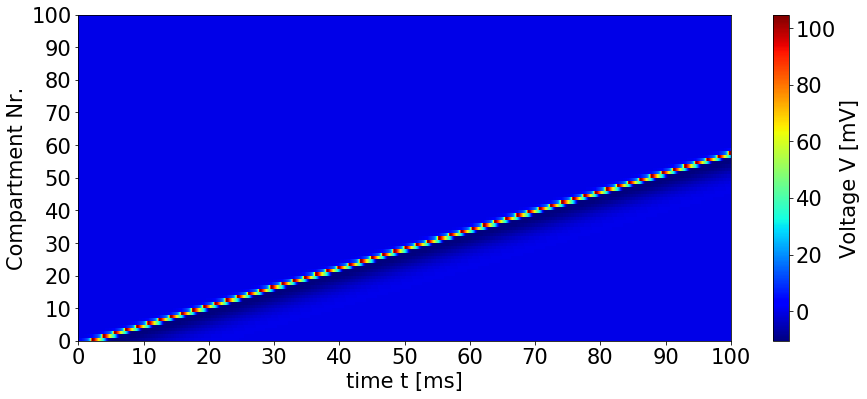

In [59]:
plt.figure(figsize=(15,6))
plt.imshow(V,
           aspect=.5,
           cmap = 'jet',
           extent=[0, 100, 0, 100],
           origin='lower',       
   
           
         )
cbar = plt.colorbar()
plt.yticks(np.arange(0,101,10))
plt.xticks(np.arange(0,101,10))
cbar.set_label('Voltage V [mV]')
plt.xlabel('time t [ms]')
plt.ylabel('Compartment Nr.')
plt.savefig('report/1.png', dpi=200, bbox_inches='tight', transparent="True", pad_inches=0)

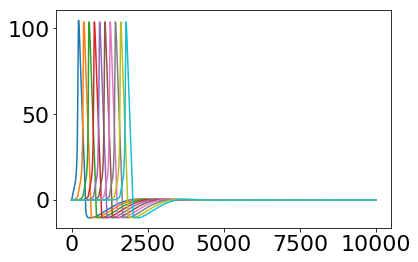

In [20]:
for n in np.arange(0,10):
    t1 = np.linspace(0, len(V[n,:]), len(V[n,:]))
    plt.plot(t1, V[n,:], label='membrane potential');


In [22]:
inp2 = np.zeros((num_comp,len(t)))
inp2[19, 1:5*one_ms] = 10
inp2[79, 1:5*one_ms] = 10
V2 = hh_model_exp_multi(num_comp, 6.3, T, dt, inp2)

10000


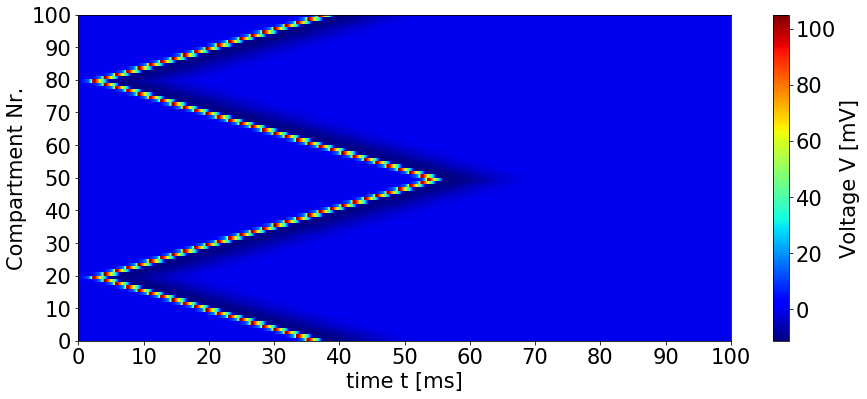

In [60]:
plt.figure(figsize=(15,6))
plt.imshow(V2,
           aspect=.5,
           cmap = 'jet',
           extent=[0, 100, 0, 100],
           origin='lower',
        
         )
cbar = plt.colorbar()
cbar.set_label('Voltage V [mV]')
plt.xlabel('time t [ms]')
plt.xlabel('time t [ms]')
plt.ylabel('Compartment Nr.')
plt.yticks(np.arange(0,101,10))
plt.xticks(np.arange(0,101,10))

plt.savefig('report/2.png', dpi=200, bbox_inches='tight', transparent="True", pad_inches=0)